In [9]:
%load_ext autoreload

import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib
from tqdm import tqdm

import numpy as onp
from jax.config import config
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot
from jax import tree_util

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning
import models

from jax.experimental import optimizers

key = random.PRNGKey(0)

from jax.scipy.stats import norm
from models import Optimizer
from collections import namedtuple
from typing import Mapping
from models import GradientLearner, SDLearner, Patience, KernelLearner, ScoreLearner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%autoreload

# How good is the score approximation?

In [47]:
scale=5.

## 1D

In [48]:
# Setup and samples
target = distributions.GaussianMixture([-3, 3], [1, 1], [1/3, 2/3])
proposal = distributions.GaussianMixture([-2, -1, 3], [2, 1, 1/2], [1,1,1])
setup = distributions.Setup(target, proposal)
n_samples = 400
training_samples = proposal.sample(n_samples)

score_gradient = models.KernelizedScoreMatcher(target, key, scale=scale)
svgd_gradient  = models.KernelGradient(target, key)

# get approx score = grad(log q)
learned_score = score_gradient.get_score(training_samples)
learned_score_scalar = utils.reshape_input(learned_score) # accept scalar input
true_score = grad(proposal.logpdf)

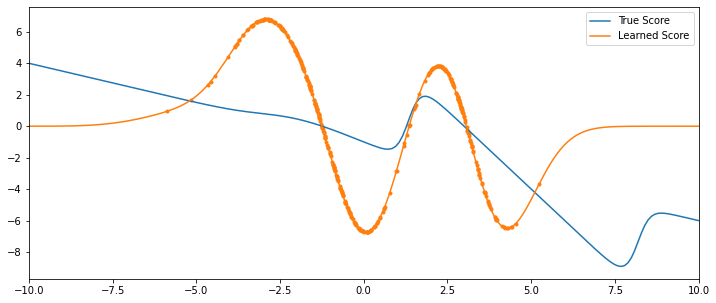

In [49]:
fig, ax = plt.subplots(figsize=[12, 5])
xlim = (-10, 10)
ax.set(xlim=xlim)
samples = proposal.sample(n_samples)

# plot the learned gradient
grid = np.linspace(*xlim, 100)
full_grid = np.concatenate([grid, np.squeeze(samples)]).sort()
full_grid = np.expand_dims(full_grid, axis=1)

plot.plot_fun(true_score, lims=xlim, ax=ax, label="True Score") 
plot.plot_fun(learned_score_scalar, lims=xlim, ax=ax, label="Learned Score")
ax.scatter(samples, vmap(learned_score)(samples), color="tab:orange", marker=".")
ax.legend()

## 2D

In [54]:
# Setup and samples
setup = distributions.banana_proposal
target, proposal = setup.get()
n_samples = 40
training_samples = proposal.sample(n_samples)

score_gradient = models.KernelizedScoreMatcher(target, key, scale=scale)
svgd_gradient  = models.KernelGradient(target, key)

# get approx score = grad(log q)
learned_score = score_gradient.get_score(training_samples)
true_score = grad(proposal.logpdf)

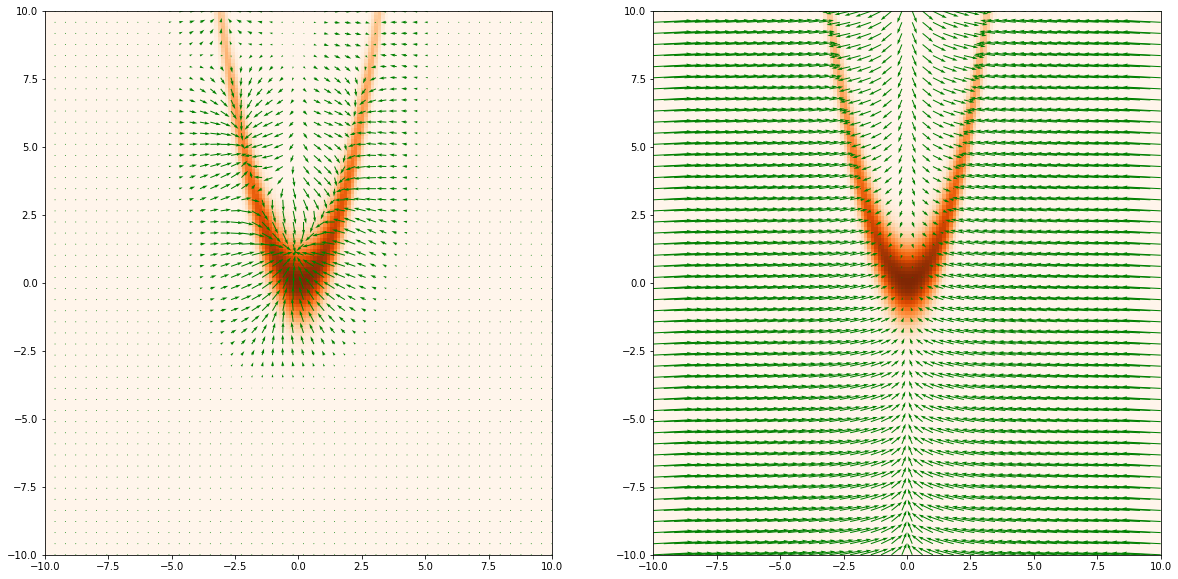

In [56]:
fig, axs = plt.subplots(1, 2, figsize=[20, 10])
axs = axs.flatten()
xlim = (-10, 10)
for ax in axs: ax.set(xlim=xlim)
samples = proposal.sample(n_samples)

# plot the learned gradient
plot.plot_fun_2d(proposal.pdf, lims=xlim, ax=axs[0])
plot.plot_gradient_field(vmap(learned_score), ax=axs[0], lims=xlim, scale=100)

# plot the true gradient
plot.plot_fun_2d(proposal.pdf, lims=xlim, ax=axs[1])
plot.plot_gradient_field(vmap(grad(proposal.logpdf)), ax=axs[1], lims=xlim, scale=100)